In [1]:
import numpy as np 
import pandas as pd 
from sklearn import preprocessing
import matplotlib.pyplot as plt 
plt.rc("font", size=14)
import seaborn as sns
sns.set(style="white") #white background style for seaborn plots
sns.set(style="whitegrid", color_codes=True)
import warnings
warnings.simplefilter(action='ignore')
warnings.filterwarnings('ignore')
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
import seaborn as sns 
import datetime 
import yfinance as yf
from scipy.interpolate import interp1d 
from scipy.stats import linregress 
import pmdarima as pm
from pmdarima.arima.utils import ndiffs

In [2]:
# Read CSV data file into DataFrame
raw_df = pd.read_csv("stock_details_5_years.csv")

In [3]:
#Examine the data
raw_df

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-29 00:00:00-05:00,43.829761,43.863354,42.639594,43.083508,167080000,0.00,0.0,AAPL
1,2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.00,0.0,MSFT
2,2018-11-29 00:00:00-05:00,54.176498,55.007500,54.099998,54.729000,31004000,0.00,0.0,GOOGL
3,2018-11-29 00:00:00-05:00,83.749496,84.499496,82.616501,83.678497,132264000,0.00,0.0,AMZN
4,2018-11-29 00:00:00-05:00,39.692784,40.064904,38.735195,39.037853,54917200,0.04,0.0,NVDA
...,...,...,...,...,...,...,...,...,...
602957,2023-11-29 00:00:00-05:00,26.360001,26.397499,26.120001,26.150000,1729147,0.00,0.0,PPL
602958,2023-11-29 00:00:00-05:00,27.680000,28.535000,27.680000,28.350000,1940066,0.00,0.0,FITB
602959,2023-11-29 00:00:00-05:00,75.940002,76.555000,75.257500,75.610001,298699,0.00,0.0,IFF
602960,2023-11-29 00:00:00-05:00,45.230000,45.259998,44.040001,44.209999,2217579,0.00,0.0,CCJ


In [4]:
# Examine the columns of the data
raw_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Dividends',
       'Stock Splits', 'Company'],
      dtype='object')

In [5]:
# Check for unique values in each column  
raw_df.nunique()

Date              1258
Open            510592
High            514315
Low             513389
Close           484353
Volume          170929
Dividends          960
Stock Splits        40
Company            491
dtype: int64

In [6]:
# Check the number of null values in each column
raw_df.isnull().sum()

Date            0
Open            0
High            0
Low             0
Close           0
Volume          0
Dividends       0
Stock Splits    0
Company         0
dtype: int64

In [7]:
# check number of records where the value is equal to 0
raw_df.eq(0).sum()

Date                 0
Open                 0
High                 0
Low                  0
Close                0
Volume             331
Dividends       596105
Stock Splits    602891
Company              0
dtype: int64

In [8]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 602962 entries, 0 to 602961
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Date          602962 non-null  object 
 1   Open          602962 non-null  float64
 2   High          602962 non-null  float64
 3   Low           602962 non-null  float64
 4   Close         602962 non-null  float64
 5   Volume        602962 non-null  int64  
 6   Dividends     602962 non-null  float64
 7   Stock Splits  602962 non-null  float64
 8   Company       602962 non-null  object 
dtypes: float64(6), int64(1), object(2)
memory usage: 41.4+ MB


In [9]:
raw_df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,602962.000000,602962.000000,602962.000000,602962.000000,6.029620e+05,602962.00000,602962.000000
mean,140.074711,141.853492,138.276316,140.095204,5.895601e+06,0.00731,0.000344
std,275.401725,279.003191,271.895276,275.477969,1.381596e+07,0.12057,0.050607
min,1.052425,1.061195,1.026114,1.034884,0.000000e+00,0.00000,0.000000
25%,39.566159,40.056222,39.058151,39.563746,1.031500e+06,0.00000,0.000000
50%,79.177964,80.125563,78.193820,79.177906,2.228700e+06,0.00000,0.000000
75%,157.837190,159.746317,155.841609,157.847153,5.277400e+06,0.00000,0.000000
max,6490.259766,6525.000000,6405.000000,6509.350098,1.123003e+09,35.00000,20.000000


### Lets ask the user to input their protfolio of stock holdings

In [10]:
# Define the list of tickers and filter the DataFrame for these tickers
tickers = ['AAPL', 'NVDA', 'MSFT', 'INTC', 'TSLA', 'CSCO']
df_portfolio = raw_df.query('Company in @tickers')
df_portfolio['Date'] = pd.to_datetime(df_portfolio['Date'])

Text(0, 0.5, 'Closing Price')

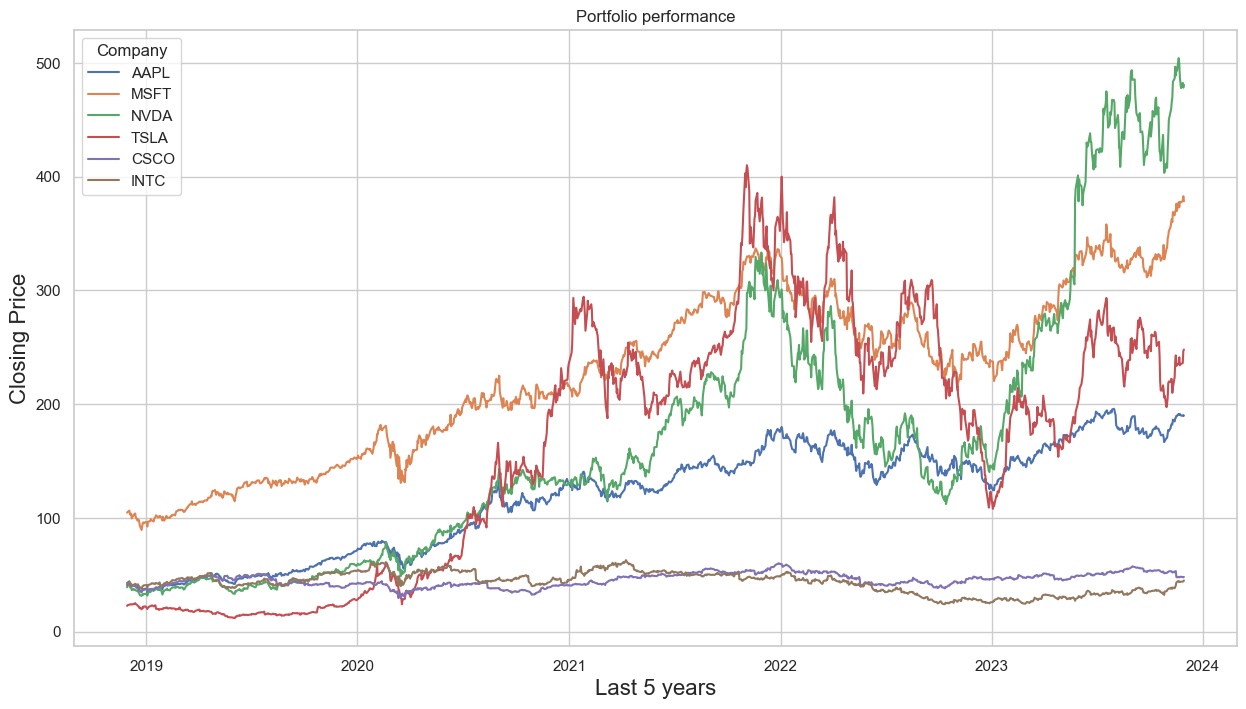

In [11]:
# Visualize the stock portfolio performance of holding
fig, visual_plot = plt.subplots(figsize=(15,8))
visual_plot = sns.lineplot(data=df_portfolio, x=df_portfolio['Date'], y=df_portfolio['Close'],hue=df_portfolio['Company'])
visual_plot.set_title("Portfolio performance")
visual_plot.set_xlabel('Last 5 years', fontsize=16)
visual_plot.set_ylabel('Closing Price' , fontsize=16)

### Using ARIMA from statsmodels to train and forecast MSFT

In [12]:
# Filter the DataFrame for Microsoft (MSFT)
msft_df = raw_df[raw_df['Company'] == 'MSFT'].copy()
# Convert the 'Date' column to datetime format and set it as the index
msft_df['Date'] = pd.to_datetime(msft_df['Date'])
msft_df = msft_df.set_index('Date')

In [13]:
msft_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
Date,,,,,,,,
2018-11-29 00:00:00-05:00,104.769074,105.519257,103.534595,104.636131,28123200,0.0,0.0,MSFT
2018-11-30 00:00:00-05:00,105.120371,105.376766,103.847914,105.300797,33665600,0.0,0.0,MSFT
2018-12-03 00:00:00-05:00,107.304460,107.703289,105.148878,106.440323,34732800,0.0,0.0,MSFT
2018-12-04 00:00:00-05:00,106.297913,106.962628,102.755913,103.050285,45197000,0.0,0.0,MSFT
2018-12-06 00:00:00-05:00,100.486371,103.733991,99.707701,103.686516,49107400,0.0,0.0,MSFT
...,...,...,...,...,...,...,...,...
2023-11-22 00:00:00-05:00,378.000000,379.790009,374.970001,377.850006,23345300,0.0,0.0,MSFT
2023-11-24 00:00:00-05:00,377.329987,377.970001,375.140015,377.429993,10176600,0.0,0.0,MSFT
2023-11-27 00:00:00-05:00,376.779999,380.640015,376.200012,378.609985,22179200,0.0,0.0,MSFT


In [14]:
## Lets consider only closing price at end of each day
msft_df = msft_df[['Close']]

In [15]:
## Train and Test split for Arima
X_train, X_test = msft_df.iloc[:-300], msft_df.iloc[-300:]
y_hist, y_future = msft_df.iloc[:-300], msft_df.iloc[-300:]

<Axes: xlabel='Date'>

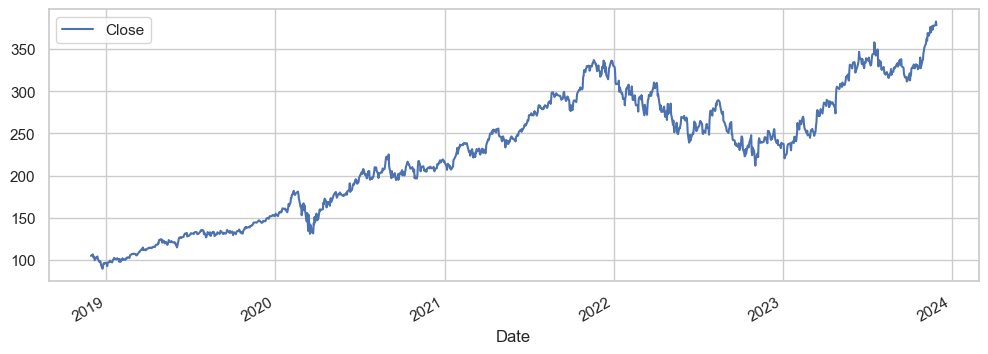

In [16]:
## Historic closing price for MSFT
msft_df.plot(figsize=(12,4))

In [17]:
# Decompose the close prices for each ticker
X_train_sd = seasonal_decompose(X_train,'additive', period = 30 )

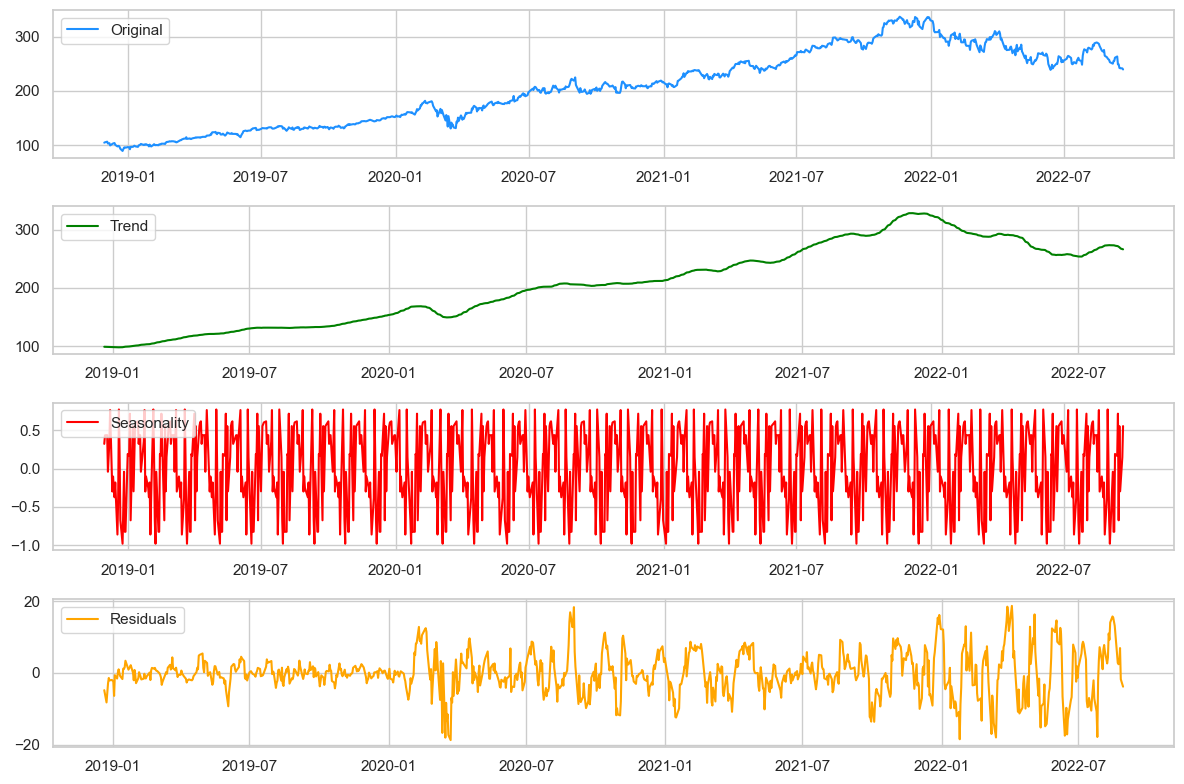

In [18]:
# get the trend, seasonality and noise 
trend = X_train_sd.trend
seasonal = X_train_sd.seasonal
residual = X_train_sd.resid

plt.figure(figsize=(12,8))
plt.subplot(411)
plt.plot(X_train, label='Original', color="dodgerblue")
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend', color="green")
plt.legend(loc='upper left')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality', color="red")
plt.legend(loc='upper left')
plt.subplot(414)
plt.plot(residual, label='Residuals', color="orange")
plt.legend(loc='best')
plt.tight_layout()

(array([17897.20833333, 18078.20833333, 18262.20833333, 18444.20833333,
        18628.20833333, 18809.20833333, 18993.20833333, 19174.20833333]),
 [Text(17897.208333333332, 0, '2019-01'),
  Text(18078.208333333332, 0, '2019-07'),
  Text(18262.208333333332, 0, '2020-01'),
  Text(18444.208333333332, 0, '2020-07'),
  Text(18628.208333333332, 0, '2021-01'),
  Text(18809.208333333332, 0, '2021-07'),
  Text(18993.208333333332, 0, '2022-01'),
  Text(19174.208333333332, 0, '2022-07')])

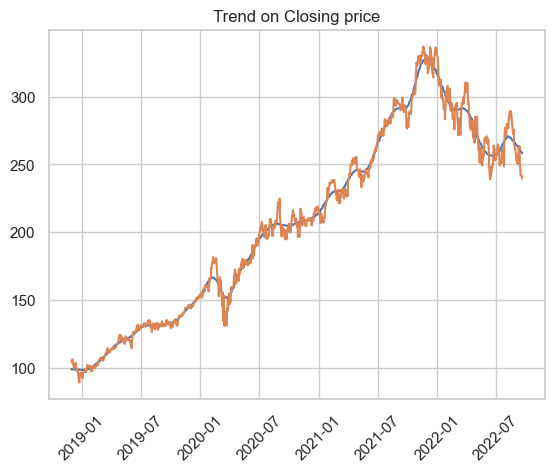

In [19]:
# Model-based forecasting using STL to remove seasonality
stl = STL(y_hist['Close'], period = 30)
results = stl.fit()
plt.plot(results.trend)
plt.plot(y_hist)
plt.title('Trend on Closing price')
plt.xticks(rotation=45)

In [20]:
# Instantiate STLF for forecasting
stlf = STLForecast(y_hist['Close'], ARIMA, period=30,model_kwargs={'order':(1, 1, 0), 'trend':"t"})
# Fit model using historical data
stlf_results = stlf.fit()
# Produce forecast for future data
stlf_forecast = stlf_results.forecast(len(y_future))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [21]:
## Forecast convert to DataFrame
ds_stlf_forecast = pd.DataFrame(stlf_forecast, columns=['Close']) 
index = (y_future[:len(y_future)].index)
ds_stlf_forecast.index = index

In [22]:
## Calculating RMSE for MSFT
msft_rmse_1 = np.sqrt(np.mean((ds_stlf_forecast - y_future) ** 2))
msft_rmse_1

38.81098584427978

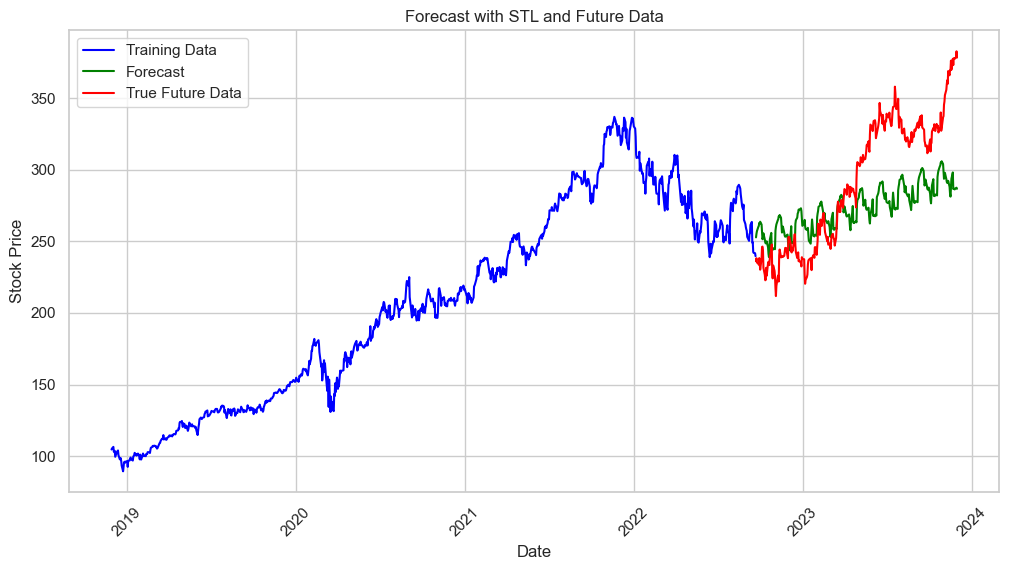

In [23]:
# Create the plot
plt.figure(figsize=(12, 6))

# Plot historical training data
plt.plot(y_hist, label='Training Data', color='blue')

# Plot forecasted data
plt.plot(ds_stlf_forecast, label='Forecast', color='green')

# Plot true future data
plt.plot(y_future, label='True Future Data', color='red')

# Add title and labels
plt.title('Forecast with STL and Future Data')
plt.xlabel('Date')
plt.ylabel('Stock Price')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Optimizing the ARIMA Model using pmdarima

In [24]:
msft_df2 = raw_df[raw_df['Company'] == 'MSFT'].copy()
msft_df2['Date'] = pd.to_datetime(msft_df2['Date'])
msft_df2 = msft_df2.set_index('Date')

In [25]:
msft_size = int(len(msft_df2) * 0.95)
msft_train = (msft_df2['Close'])[:msft_size]
msft_test = (msft_df2['Close'])[msft_size:]

In [26]:
msft_model = pm.auto_arima(msft_train, test = 'adf', 
                        start_p = 1, start_q = 1,     
                        max_p = 3, max_q = 3,
                        d = None, seasonal = True,   
                        start_P = 0, m = 3,
                        trace = True, error_action = 'ignore',  
                        suppress_warnings = True, stepwise = True,
                        D = 1, information_criterion = 'aic')

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=7984.767, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=7251.481, Time=0.08 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=7512.308, Time=0.09 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=7990.520, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=7467.916, Time=0.03 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=7042.862, Time=0.18 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=0.38 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.44 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=7973.068, Time=0.12 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=7043.746, Time=0.30 sec
 ARIMA(1,0,1)(2,1,0)[3] intercept   : AIC=7043.901, Time=0.25 sec
 ARIMA(0,0,1)(2,1,0)[3] intercept   : AIC=7500.814, Time=0.17 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   : AIC=7046.326, Time=0.84 sec
 ARIMA(1,0,0)(2,1,0)[3]             : AIC=7043.2

In [27]:
# Forecasting using pmdarima
msft_forecast = msft_model.predict(X = msft_test, n_periods = len(msft_test))

/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [28]:
msft_forecast_ds = pd.Series(msft_forecast) 
index = (msft_test[:len(msft_test)].index)
msft_forecast_ds.index = index

In [29]:
## Calculating RMSE for MSFT
msft_rmse = np.sqrt(np.mean((msft_forecast_ds - msft_test) ** 2))
msft_rmse

18.55815912772174

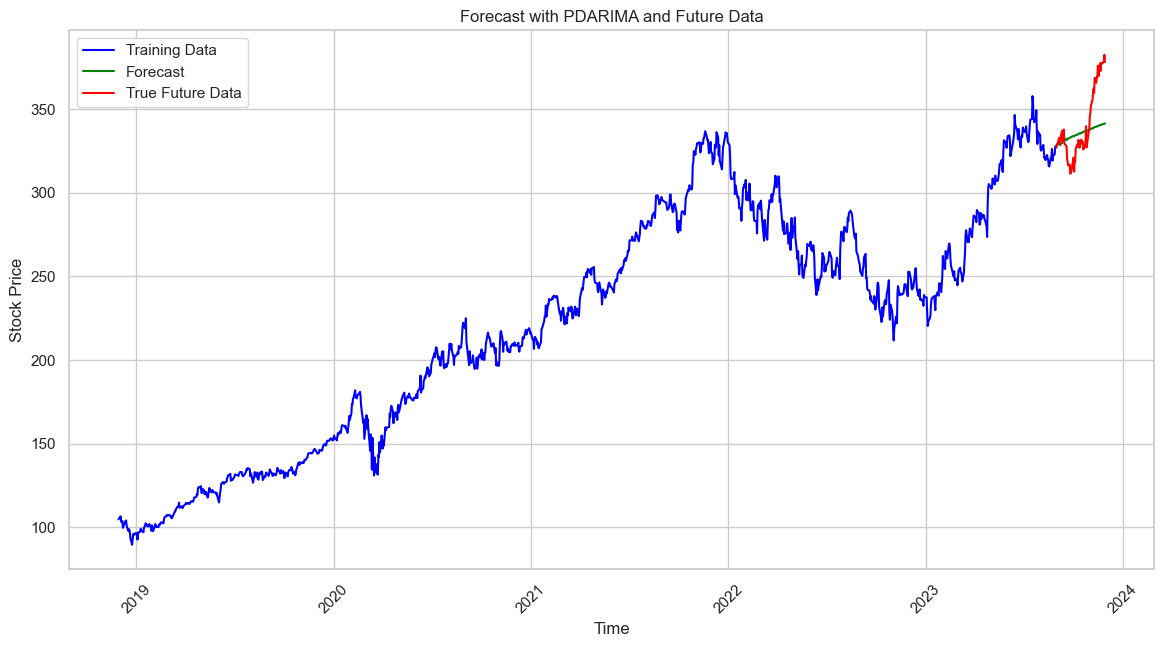

In [30]:
# Create the plot
plt.figure(figsize=(14, 7))

# Plot historical training data
plt.plot(msft_train, label='Training Data', color='blue')

# Plot forecasted data
plt.plot(msft_forecast_ds, label='Forecast', color='green')

# Plot true future data
plt.plot(msft_test, label='True Future Data', color='red')

# Add title and labels
plt.title('Forecast with PDARIMA and Future Data')
plt.xlabel('Time')
plt.ylabel('Stock Price')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Comparing RMSE between ARIMA and PDARIMA. PDARIMA performs better. 

### Defining a function to perform prediction using PDARIMA for portfolio


In [31]:
# Function to split the data into 95% train and 5% test
def train_test_split(dataframe, company):
    size = int(len(dataframe) * 0.95)
    train = (dataframe['Close'])[:size]
    test = (dataframe['Close'])[size:]
    return train, test

In [32]:
# Function to find the best parameters for pdarima
def find_best_param_arima(data, company):
    print('Find best ARIMA parameter for {} '.format(company))

    model = pm.auto_arima(data, test = 'adf', 
                          start_p = 1, start_q = 1,     
                          max_p = 3, max_q = 3,
                          d = None, seasonal = True,   
                          start_P = 0, m = 3,
                          trace = True, error_action = 'ignore',  
                          suppress_warnings = True, stepwise = True,
                          D = 1, information_criterion = 'aic')
   
    return model

In [33]:
# Function to display the best Arima parameters for each stock ticker
def best_param_arima(model, company):
    print('The best parameters for {} are {}'.format(company, model))

In [34]:
# Function to predict the stock price and calculate RMSE
def predictions_calc_rmse(model, test_data, company):
    print('For {} '.format(company))
    forecast = model.predict(X = test_data, n_periods = len(test_data))
    forecast_ds = pd.Series(forecast) 
    index = (test_data[:len(test_data)].index)
    forecast_ds.index = index
    rmse = np.sqrt(np.mean((forecast_ds - test_data) ** 2))
    
    print('The RMSE is {}'.format(rmse))
    
    return forecast_ds

In [35]:
# Function to plot train, test, and forecasted price for each stock ticker
def plot_predictions(train_data, test_data, forecast_data, company):
    plt.figure(figsize=(14, 7))
    plt.plot(train_data, label='Training Data', color='blue')
    plt.plot(test_data, label='True Future Data', color='red')
    plt.plot(forecast_data, label='Forecast', color='green')
    plt.title(f'Forecast with ARIMA for {company}')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.show()

In [36]:
tickers = ['AAPL', 'NVDA', 'MSFT', 'INTC', 'TSLA', 'CSCO']

In [37]:
# Display the portfolio tickers
i = 0
while i < len(tickers):
  print(tickers[i])
  i = i + 1

AAPL
NVDA
MSFT
INTC
TSLA
CSCO


In [38]:
# Create a DataFrame for each stock ticker
df_1 = raw_df[raw_df['Company'] == tickers[0]].copy()
df_2 = raw_df[raw_df['Company'] == tickers[1]].copy()
df_3 = raw_df[raw_df['Company'] == tickers[2]].copy()
df_4 = raw_df[raw_df['Company'] == tickers[3]].copy()
df_5 = raw_df[raw_df['Company'] == tickers[4]].copy()
df_6 = raw_df[raw_df['Company'] == tickers[5]].copy()

In [39]:
# Set index to Date
df_1['Date'] = pd.to_datetime(df_1['Date'])
df_2['Date'] = pd.to_datetime(df_2['Date'])
df_3['Date'] = pd.to_datetime(df_3['Date'])
df_4['Date'] = pd.to_datetime(df_4['Date'])
df_5['Date'] = pd.to_datetime(df_5['Date'])
df_6['Date'] = pd.to_datetime(df_6['Date'])

In [40]:
df_1 = df_1.set_index('Date')
df_2 = df_2.set_index('Date')
df_3 = df_3.set_index('Date')
df_4 = df_4.set_index('Date')
df_5 = df_5.set_index('Date')
df_6 = df_6.set_index('Date')

In [41]:
# Split the data into train and test for each stock tickers
df_1_train, df_1_test = train_test_split(df_1, tickers[0])
df_2_train, df_2_test = train_test_split(df_2, tickers[1])
df_3_train, df_3_test = train_test_split(df_3, tickers[2])
df_4_train, df_4_test = train_test_split(df_4, tickers[3])
df_5_train, df_5_test = train_test_split(df_5, tickers[4])
df_6_train, df_6_test = train_test_split(df_6, tickers[5])

In [42]:
# Find the best parameters model pdarima for each stock tickers 
df_1_arima_model = find_best_param_arima(df_1_train, tickers[0])
df_2_arima_model = find_best_param_arima(df_2_train, tickers[1])
df_3_arima_model = find_best_param_arima(df_3_train, tickers[2])
df_4_arima_model = find_best_param_arima(df_4_train, tickers[3])
df_5_arima_model = find_best_param_arima(df_5_train, tickers[4])
df_6_arima_model = find_best_param_arima(df_6_train, tickers[5])

Find best ARIMA parameter for AAPL 
Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=0.39 sec
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=6650.042, Time=0.01 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=5806.861, Time=0.07 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=6150.884, Time=0.07 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=6657.624, Time=0.01 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=6054.100, Time=0.02 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=5667.553, Time=0.16 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.29 sec
 ARIMA(0,0,0)(2,1,0)[3] intercept   : AIC=6650.599, Time=0.09 sec
 ARIMA(2,0,0)(2,1,0)[3] intercept   : AIC=5666.292, Time=0.23 sec
 ARIMA(2,0,0)(1,1,0)[3] intercept   : AIC=5804.139, Time=0.12 sec
 ARIMA(2,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=0.93 sec
 ARIMA(2,0,0)(1,1,1)[3] intercept   : AIC=inf, Time=0.46 sec
 ARIMA(2,0,1)(2,1,0)[3

 ARIMA(0,0,1)(2,1,0)[3] intercept   : AIC=3435.237, Time=0.13 sec
 ARIMA(2,0,1)(2,1,0)[3] intercept   : AIC=2954.133, Time=0.86 sec
 ARIMA(2,0,1)(1,1,0)[3] intercept   : AIC=3106.637, Time=0.26 sec
 ARIMA(2,0,1)(2,1,1)[3] intercept   : AIC=inf, Time=1.08 sec
 ARIMA(2,0,1)(1,1,1)[3] intercept   : AIC=inf, Time=0.48 sec
 ARIMA(2,0,2)(2,1,0)[3] intercept   : AIC=inf, Time=0.61 sec
 ARIMA(1,0,2)(2,1,0)[3] intercept   : AIC=inf, Time=0.40 sec
 ARIMA(2,0,1)(2,1,0)[3]             : AIC=2952.448, Time=0.43 sec
 ARIMA(2,0,1)(1,1,0)[3]             : AIC=3104.935, Time=0.15 sec
 ARIMA(2,0,1)(2,1,1)[3]             : AIC=inf, Time=0.81 sec
 ARIMA(2,0,1)(1,1,1)[3]             : AIC=inf, Time=0.62 sec
 ARIMA(1,0,1)(2,1,0)[3]             : AIC=2957.604, Time=0.08 sec
 ARIMA(2,0,0)(2,1,0)[3]             : AIC=2957.602, Time=0.08 sec
 ARIMA(2,0,2)(2,1,0)[3]             : AIC=inf, Time=0.42 sec
 ARIMA(1,0,0)(2,1,0)[3]             : AIC=2955.614, Time=0.07 sec
 ARIMA(1,0,2)(2,1,0)[3]             : AIC=inf

In [43]:
# Display the best pdarima parameters
best_param_arima(df_1_arima_model, tickers[0])
best_param_arima(df_2_arima_model, tickers[1])
best_param_arima(df_3_arima_model, tickers[2])
best_param_arima(df_4_arima_model, tickers[3])
best_param_arima(df_5_arima_model, tickers[4])
best_param_arima(df_6_arima_model, tickers[5])

The best parameters for AAPL are  ARIMA(2,0,1)(2,1,0)[3] intercept
The best parameters for NVDA are  ARIMA(2,0,0)(2,1,0)[3] intercept
The best parameters for MSFT are  ARIMA(1,0,0)(2,1,0)[3] intercept
The best parameters for INTC are  ARIMA(1,0,0)(2,1,2)[3]          
The best parameters for TSLA are  ARIMA(2,0,0)(2,1,0)[3]          
The best parameters for CSCO are  ARIMA(2,0,1)(2,1,0)[3]          


In [44]:
# Forecast the stock price for each stock tickers and find the RMSE
df_1_forecast = predictions_calc_rmse(df_1_arima_model, df_1_test, tickers[0])
df_2_forecast = predictions_calc_rmse(df_2_arima_model, df_2_test, tickers[1])
df_3_forecast = predictions_calc_rmse(df_3_arima_model, df_3_test, tickers[2])
df_4_forecast = predictions_calc_rmse(df_4_arima_model, df_4_test, tickers[3])
df_5_forecast = predictions_calc_rmse(df_5_arima_model, df_5_test, tickers[4])
df_6_forecast = predictions_calc_rmse(df_6_arima_model, df_6_test, tickers[5])

For AAPL 
The RMSE is 14.283853821906252
For NVDA 
The RMSE is 73.12644498887494
For MSFT 
The RMSE is 18.55815912772174
For INTC 
The RMSE is 4.780454443032572
For TSLA 
The RMSE is 33.49895399526995
For CSCO 
The RMSE is 4.588176407781871


/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.11/site-packages/stat

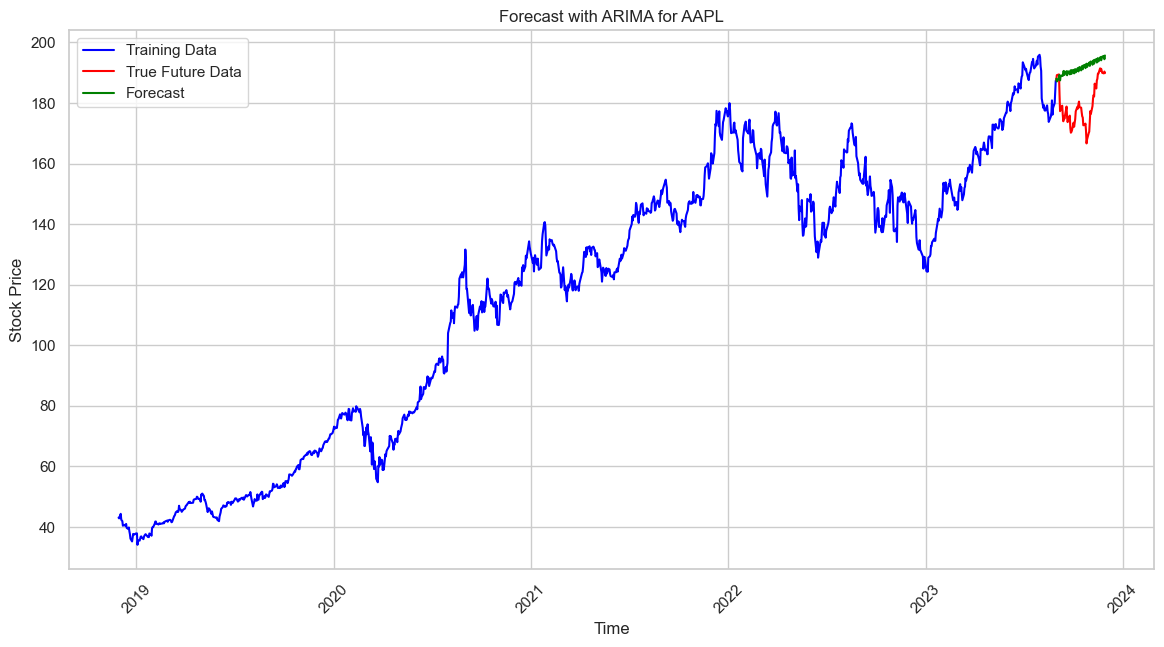

In [45]:
# Plot the train, test and forecasted price for each stock ticker 
plot_predictions(df_1_train, df_1_test, df_1_forecast, tickers[0])

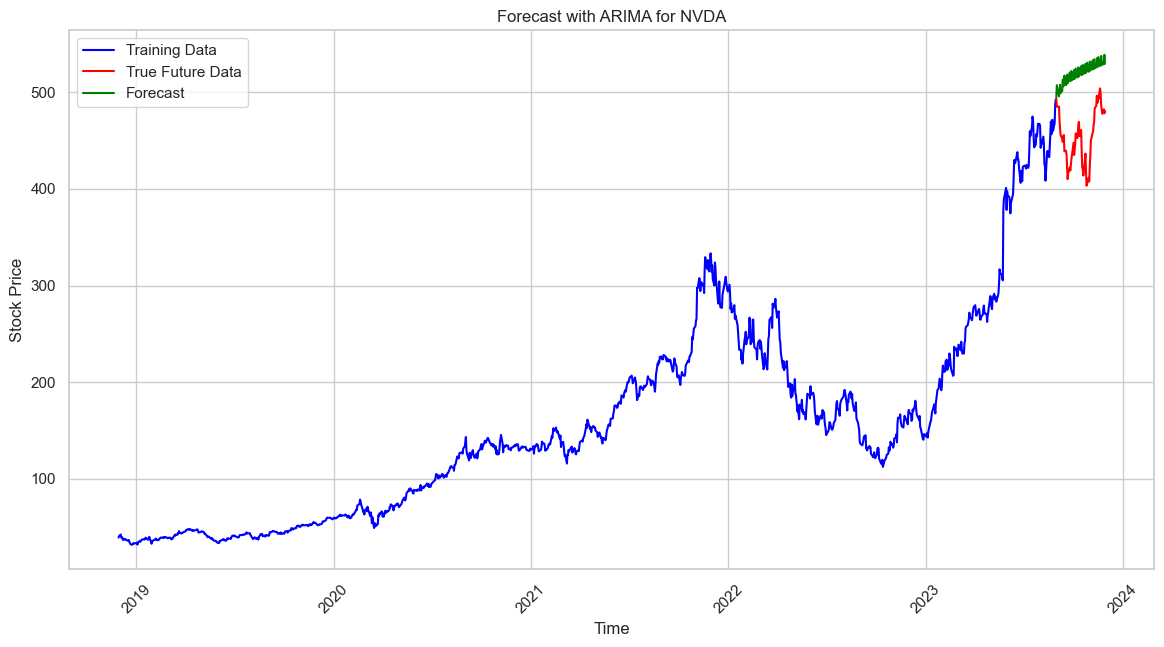

In [46]:
plot_predictions(df_2_train, df_2_test, df_2_forecast, tickers[1])

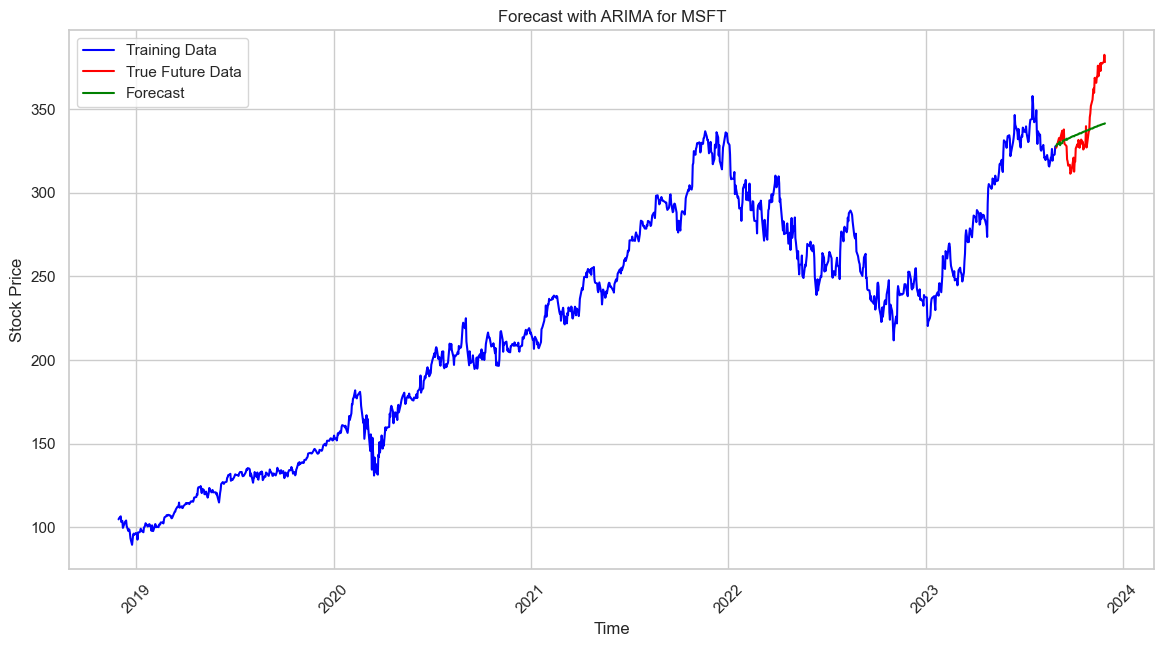

In [47]:
plot_predictions(df_3_train, df_3_test, df_3_forecast, tickers[2])

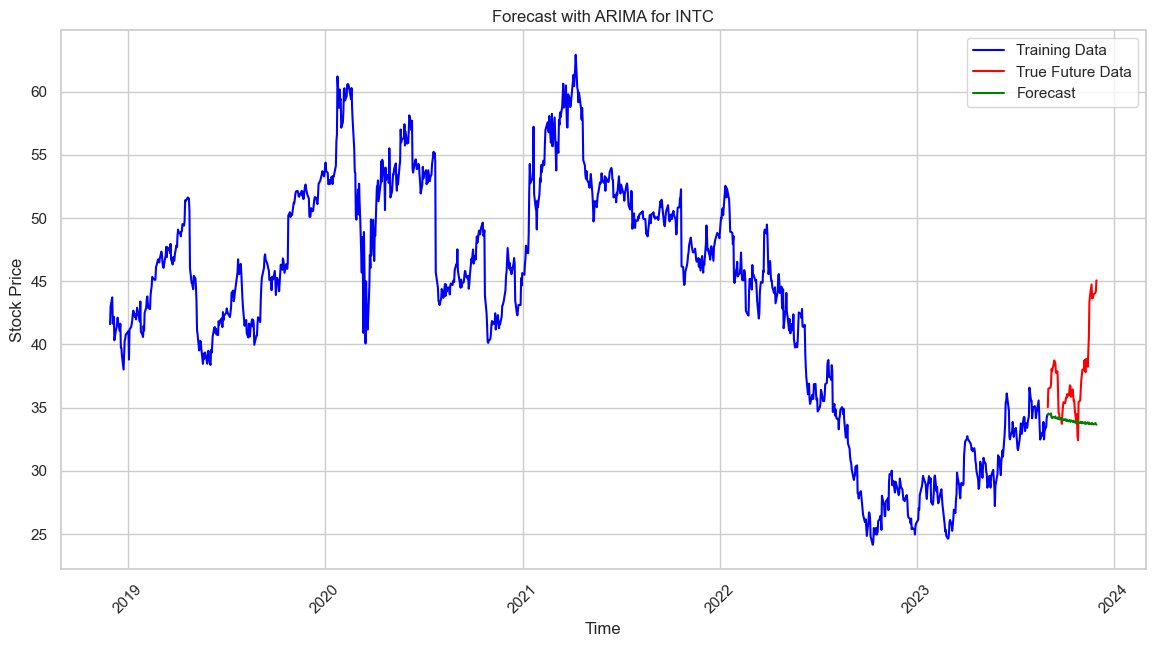

In [48]:
plot_predictions(df_4_train, df_4_test, df_4_forecast, tickers[3])

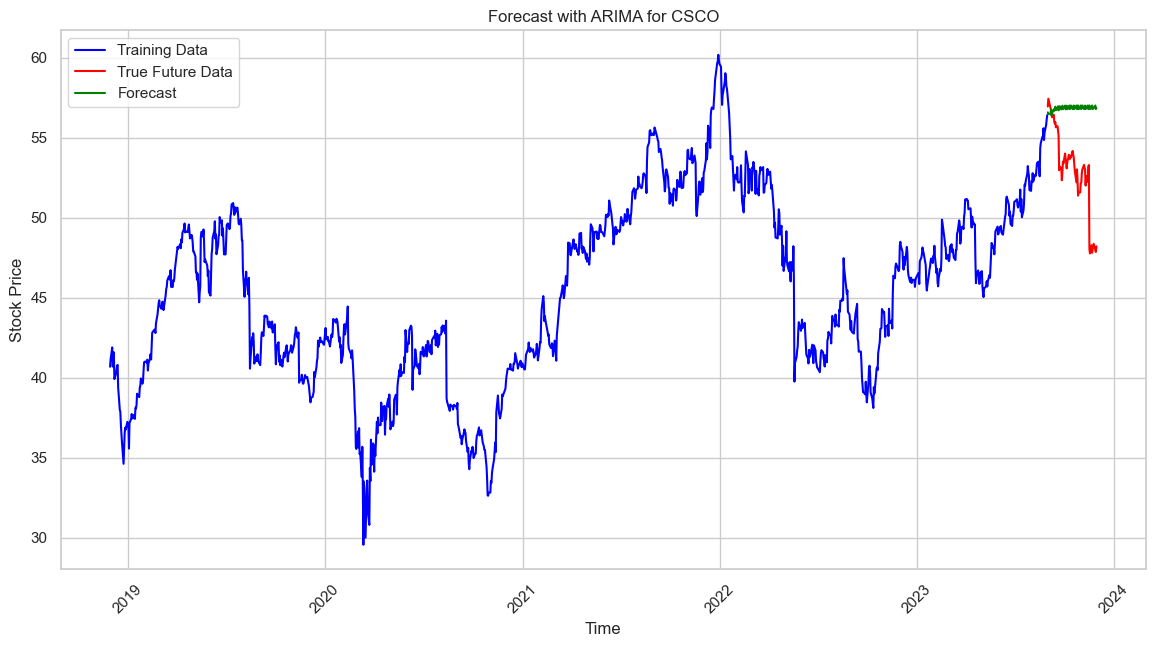

In [49]:
plot_predictions(df_6_train, df_6_test, df_6_forecast, tickers[5])